<a href="https://colab.research.google.com/github/SNakatsuka/defect_recognition/blob/main/defect_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/colab')

11
8
4


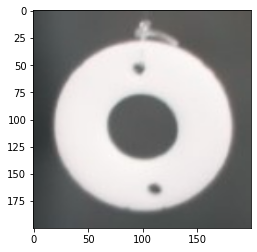

In [ ]:

# ライブラリのインポート
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
import glob

# ディレクトリの変更
os.chdir('/content/drive/My Drive/colab/defect_recognition')


# ファイルパスの設定
path_OK = os.listdir('./OK')
path_DEFECT = os.listdir('./DEFECT')
path_JUDGE = os.listdir('./JUDGE')

# データを合格、不合格、検証用に分類
img_OK = []
img_DEFECT = []
img_JUDGE=[]

print(len(path_OK))
print(len(path_DEFECT))
print(len(path_JUDGE))


for i in range(len(path_OK)):
    img = cv2.imread('./OK/' + path_OK[i])
    img = cv2.resize(img, (200,200))
    img_OK.append(img)
    plt.imshow(img)

for i in range(len(path_DEFECT)):
    img = cv2.imread('./DEFECT/' + path_DEFECT[i])
    img = cv2.resize(img, (200,200))
    img_DEFECT.append(img)
    plt.imshow(img)

# 検証用データ
for i in range(len(path_JUDGE)):
    img = cv2.imread('./JUDGE/' + path_JUDGE[i])
    img = cv2.resize(img, (200,200))
    img_JUDGE.append(img)
    plt.imshow(img)

X = np.array(img_OK + img_DEFECT)
y =  np.array([0]*len(img_OK) + [1]*len(img_DEFECT))



In [ ]:
rand_index = np.random.permutation(np.arange(len(X)))
X = X[rand_index]
y = y[rand_index]

# データの分割
X_train = X[:int(len(X)*0.8)]
y_train = y[:int(len(y)*0.8)]
X_test = X[int(len(X)*0.8):]
y_test = y[int(len(y)*0.8):]

# categorical_crossentropyとともに用いるためのバイナリのクラス行列に変換
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)




In [ ]:
# モデルにvggを使用
input_tensor = Input(shape=(200, 200, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# vggのoutputを受け取り、2クラス分類する層を定義します
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(2, activation='softmax'))

# vggと、top_modelを連結
model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# vggの層の重みを変更不能にします
for layer in model.layers[:19]:
    layer.trainable = False

# コンパイルします
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])




58889256/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
# 学習を行います
model.fit(X_train, y_train, batch_size=16, epochs=15, validation_data=(X_test, y_test))






Epoch 1/15
1/1 [==============================] - 9s 9s/step - loss: 10.9346 - accuracy: 0.6000 - val_loss: 25.1253 - val_accuracy: 0.2500
Epoch 2/15
1/1 [==============================] - 8s 8s/step - loss: 21.9805 - accuracy: 0.4667 - val_loss: 9.0796 - val_accuracy: 0.7500
Epoch 3/15
1/1 [==============================] - 8s 8s/step - loss: 23.0207 - accuracy: 0.5333 - val_loss: 0.8386 - val_accuracy: 0.7500
Epoch 4/15
1/1 [==============================] - 8s 8s/step - loss: 6.4611 - accuracy: 0.6667 - val_loss: 39.9687 - val_accuracy: 0.2500
Epoch 5/15
1/1 [==============================] - 9s 9s/step - loss: 30.9360 - accuracy: 0.4667 - val_loss: 19.4233 - val_accuracy: 0.2500
Epoch 6/15
1/1 [==============================] - 8s 8s/step - loss: 10.1267 - accuracy: 0.6667 - val_loss: 2.2356 - val_accuracy: 0.7500
Epoch 7/15
1/1 [==============================] - 8s 8s/step - loss: 6.6099 - accuracy: 0.6000 - val_loss: 1.0736 - val_accuracy: 0.7500
Epoch 8/15
1/1 [=================

In [ ]:
# ディレクトリの変更
os.chdir('/content/drive/My Drive/colab/defect_recognition')

# 重みを保存
result_dir = 'results'
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
model.save("model.h5")


Quantized model size = 19052KBs.


19509296

In [ ]:
import tensorflow as tf

# Convert the model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Quantize the model
def representative_dataset_gen():
   for i in range(100):
      input_image = tf.cast(test_images[i], tf.float32)
      input_image = tf.reshape(input_image, [1,28,28])
      yield ([input_image])

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Quantized model size = %dKBs.' % float_model_size)
# Save the model to disk
open('qmodel.tflite', "wb").write(tflite_float_model)


In [ ]:
# 画像を一枚受け取り、合格か不合格かを判定する関数

def pred_quality(img):
    img = cv2.resize(img, (200, 200))
    plt.imshow(img)
    pred = np.argmax(model.predict(np.array([img])))
    if pred == 0:
        return 'OK'
    else:
        return 'DEFECT'
    

# 精度の評価
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])



1/1 [==============================] - 2s 2s/step - loss: 22.3462 - accuracy: 0.2500
Test loss: 22.346195220947266
Test accuracy: 0.25


In [ ]:
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input

# 画像のロード & 正規化
img = img_to_array(load_img("./JUDGE/JUDGE2.jpg", target_size=(200, 200)))
input_img = preprocess_input(img)

# TFliteモデルのロード
interpreter = tf.lite.Interpreter(model_path = "qmodel.tflite")
interpreter.allocate_tensors()

# モデルの入出力情報の取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 入力画像のshapeを整形
input_data = np.expand_dims(input_img, axis = 0)

# 予測
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
pred = output_data.argmax(axis = 1)

# 予測結果の出力
print(output_data.argmax(axis = 1))

if pred == 0:
    print('OK')
else:
    print('DEFECT')


[0]
OK


In [ ]:
# 検証用データでテストを行う
import os
import glob
files_list=[]
path = "/content/drive/My Drive/colab/defect_recognition/JUDGE"
files = glob.glob(path + "/*")
for f in files:
    files_list.append(os.path.basename(f))

print(files_list)

count=0
for i in img_JUDGE:
  plt.imshow(i)
  if count==0:
    print("ファイル名:" + files_list[0])
  else:
    print("ファイル名:" + files_list[count])
  count+=1
  print("判定結果:" + pred_quality(i))

NameError: ignored